In [1]:
import tensorflow as tf

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import h5py
import cv2
import time
import video_recognition_library as vrl
import video_cnn_recognition_library as cnn

In [19]:
from keras.layers import Activation, Conv3D
from keras.layers import BatchNormalization
from keras.layers import Reshape, Dense
from keras.models import Model, load_model
from keras.layers import Input, add
from keras.layers import MaxPooling3D, GlobalMaxPooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [20]:
base_path = 'bin\\'

In [21]:
metadata = pd.read_csv(base_path + 'metadata.csv')
metadata = metadata.loc[metadata.modality == 'video']

In [22]:
len(metadata)

4

In [28]:
def process_for_frames(tensor):
    tensor = cnn.grayscale(tensor)
    tensor = cnn.get_few_frames(tensor, center=tensor.shape[0]//2, n_points=4, step=7)
    return tensor

In [37]:
def generator_few_frames(batch_size=16, metadata=metadata):
    return vrl.generator_few_frames(batch_size, metadata, base_path, "data.h5", "labels.h5", process_for_frames)

In [38]:
g = generator_few_frames()
print(g)

In [40]:
x, label = next(g)


In [41]:
x.shape

(4, 5, 200, 200, 1)

sad


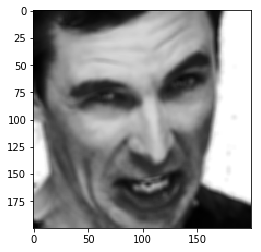

In [43]:
print(vrl.emotions[label[1].argmax()])
imshow(x[1][1].reshape(200, 200), cmap='gray')

In [44]:
def model_first(input_shape=(5, 200, 200, 1), num_classes=8, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv3D(4, (1, 2, 2), 
               strides=(1, 1, 1), 
               kernel_regularizer=regularization,
               use_bias=False, 
               padding='same')(img_input)
    x = MaxPooling3D((2, 2, 2), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv3D(8, (1, 2, 2), 
               strides=(1, 1, 1), 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # module 1
    
    residual = Conv3D(8, 
                      (1, 2, 2), 
                      strides=(1, 2, 2),
                      padding='same', 
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = Conv3D(8, (2, 2, 2), 
               padding='same',
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(8, (2, 2, 2), 
               padding='same',
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling3D((3, 3, 3), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    x = add([x, residual])
    x = Conv3D(4, (1, 2, 2), 
               padding='valid', 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = MaxPooling3D((1, 3, 3), 
                     strides=(1, 3, 3), 
                     padding='valid')(x)
    x = Activation('relu')(x)
    
    shape = (int(x.shape[1]), 
             int(x.shape[2]*x.shape[3]*x.shape[4]))
    x = Reshape(shape)(x)
    x = GlobalMaxPooling1D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(img_input, output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [45]:
def model_second(input_shape=(5, 200, 200, 1), num_classes=8, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    img_input = Input(input_shape)
    x = Conv3D(4, (1, 2, 2), 
               strides=(1, 1, 1), 
               kernel_regularizer=regularization,
               use_bias=False, 
               padding='same')(img_input)
    x = MaxPooling3D((2, 2, 2), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv3D(8, (1, 2, 2), 
               strides=(1, 1, 1), 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
        
    residual = Conv3D(8, (1, 2, 2), 
                      strides=(1, 2, 2),
                      padding='same', 
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = Conv3D(8, (2, 2, 2), 
               padding='same',
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(8, (2, 2, 2), 
               padding='same',
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling3D((3, 3, 3), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    x = add([x, residual])
    
    x = Conv3D(4, (1, 2, 2), 
               padding='valid', 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((1, 3, 3), 
                     strides=(1, 2, 2), 
                     padding='valid')(x)
        
    residual = Conv3D(4, (1, 2, 2), 
                      strides=(1, 2, 2),
                      padding='same', 
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = Conv3D(4, (2, 3, 3), 
               padding='same', 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((1, 2, 2), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    
    x = add([x, residual])
    
    shape = (int(x.shape[1]), 
             int(x.shape[2]*x.shape[3]*x.shape[4]))
    x = Reshape(shape)(x)
    x = GlobalMaxPooling1D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(img_input, output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [46]:
def model_third(input_shape=(5, 200, 200, 1), num_classes=8, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    img_input = Input(input_shape)
    x = Conv3D(4, (1, 2, 2), 
               strides=(1, 1, 1), 
               kernel_regularizer=regularization,
               use_bias=False, 
               padding='same')(img_input)
    x = MaxPooling3D((2, 2, 2), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv3D(8, (1, 2, 2), 
               strides=(1, 1, 1), 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    residual = Conv3D(8, (1, 2, 2), 
                      strides=(1, 2, 2),
                      padding='same', 
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = Conv3D(8, (2, 2, 2), 
               padding='same',
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(8, (2, 2, 2), 
               padding='same',
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling3D((3, 3, 3), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    x = add([x, residual])
    
    x = Conv3D(4, (1, 2, 2), 
               padding='valid', 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((1, 3, 3), 
                     strides=(1, 2, 2), 
                     padding='valid')(x)
        
    residual = Conv3D(4, (1, 2, 2), 
                      strides=(1, 2, 2),
                      padding='same', 
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = Conv3D(4, (2, 3, 3), 
               padding='same', 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((1, 2, 2), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    
    x = add([x, residual])
    
    residual = Conv3D(4, (1, 2, 2), 
                      strides=(1, 2, 2),
                      padding='same', 
                      use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = Conv3D(4, (2, 3, 3), 
               padding='same', 
               kernel_regularizer=regularization,
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((1, 2, 2), 
                     strides=(1, 2, 2), 
                     padding='same')(x)
    
    x = add([x, residual])
    
    shape = (int(x.shape[1]), 
             int(x.shape[2]*x.shape[3]*x.shape[4]))
    x = Reshape(shape)(x)
    x = GlobalMaxPooling1D()(x)
    output = Dense(8, activation='softmax')(x)
    model = Model(img_input, output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [47]:
model = model_third()

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 200, 200,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 5, 200, 200,  16          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 5, 100, 100,  0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 5, 100, 100,  16          max_pooling3d_1[0][0]            
__________________________________________________________________________________________________
activation

In [49]:
model_name = 'model_11_20_2093_3'
file_path = model_name + '.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=20)
tensor_board = TensorBoard(log_dir='./logs/' + model_name, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
callbacks_list = [checkpoint, early, tensor_board] 

Instructions for updating:
Use the retry module or similar alternatives.


In [50]:
batch_size = 16
epochs = 20

In [51]:
metadata = metadata.sample(frac=1, random_state=42)

In [52]:
train = metadata.iloc[:int(0.8*metadata.shape[0])]
test = metadata.iloc[int(0.8*metadata.shape[0]):]

In [53]:
gen_train = generator_few_frames(batch_size, train)
gen_test = generator_few_frames(batch_size, test)

In [54]:
validation_steps=test.shape[0]//batch_size
print(test.shape[0])
print(batch_size)

1
16


In [55]:
model.fit_generator(gen_train, 
                    epochs=epochs, 
                    steps_per_epoch=train.shape[0]//batch_size, 
                    validation_data=gen_test, 
                    callbacks=callbacks_list,
                    validation_steps=test.shape[0]//batch_size
                   )

ValueError: `validation_steps=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `validation_steps` or use the `keras.utils.Sequence` class.